import required packages

In [1]:
# Third party packages.
import pandas as pd             # Data handling
import numpy as np              # Numeric calculations
import pickle                   # Save and load data
import altair as alt            # Visualize data
# import seaborn as sns           # Visualize data
import matplotlib.pyplot as plt # Visualize data
import json
from scipy.stats import pearsonr # Correlation

load csv file

In [2]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
csv_file_path = f'{DOWNLOAD_DIR}/power-gen-consolidated-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    dc_ned_json_data_1 = pd.read_csv(csv_file)
# df_ned_json_data = dc_ned_json_data_1['df_orig']
df_ned_json_data = pd.DataFrame(dc_ned_json_data_1)  # Convert dictionary to DataFrame

DOWNLOAD_DIR : ../data/powergen/


set pandas dataframe settings

In [3]:
# Setting Pandas options.
pd.set_option("display.max_rows", 50) # How to display all rows from data frame using pandas. Setting value to None to show all rows.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)
pd.set_option("display.max_info_rows", 1000000)
pd.set_option("display.precision", 2)
#pd.set_option("styler.format.precision", 2)

Descriptive analytics

In [4]:
# Show a sample of first 3 rows.
df_ned_json_data.head(3)

,validto,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,production_cofiring,capacity_9,production_geothermal,capacity_10,production_other,capacity_11,production_waste,capacity_12,production_biooil,capacity_13,production_biomass,capacity_14,production_wood,capacity_17,production_windoffshore,capacity_18,production_fossilgaspower,capacity_19,production_fossilhardcoal,capacity_20,production_nuclear,capacity_21,production_wastepower,capacity_22,production_windoffshoreB,capacity_25,production_biomasspower,capacity_26,production_otherpower,capacity_27,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas
0,2022-01-01 00:00:00+00:00,8098513,8098513,2031015,2031015,0,0,161795,161795,699000,699000,136032,136032,55998,55998,458627,458627,913004,913004,872107,872107,336949,336949,1364456,1364456,1714000,1714000,1926636,1926636,485000,485000,408500,408500,1865500,1865500,447364,447364,241000,241000,10246506,10246506,NaN,NaN,1127491,1127491,482,482,1865500,1865500
1,2022-01-01 01:00:00+00:00,7914843,7914843,1864849,1864849,0,0,198870,198870,699000,699000,135768,135768,55998,55998,458131,458131,913011,913011,871174,871174,310137,310137,1290465,1290465,1823000,1823000,1592074,1592074,485000,485000,407250,407250,1839500,1839500,646176,646176,241000,241000,10083044,10083044,NaN,NaN,1184195,1184195,391,391,1839500,1839500
2,2022-01-01 02:00:00+00:00,7442013,7442013,1784513,1784513,0,0,222172,222172,698995,698995,135582,135582,55996,55996,457782,457782,913018,913018,870521,870521,305717,305717,1345134,1345134,1956250,1956250,1500851,1500851,485000,485000,407750,407750,1429250,1429250,609149,609149,241000,241000,9595627,9595627,NaN,NaN,1181864,1181864,444,444,1429250,1429250


Data Understanding

a. Which variables are numerical and which can categorical? How many variables are of both types?

In [5]:
print(
    f"Number of columns in the original data: "
    f"{df_ned_json_data.shape[1]}"
    "\n"
)

df_orig_num    = df_ned_json_data.select_dtypes(include='number')
l_df_num_names = df_orig_num.columns.tolist()

print(f"\nNumber of numerical variables: {len(l_df_num_names)}")
print(l_df_num_names)


df_orig_cat    = df_ned_json_data.select_dtypes(include='object')
l_df_cat_names = list(df_orig_cat.columns)

print(f"\nNumber of categorical variables: {len(l_df_cat_names)}")
print(l_df_cat_names)


Number of columns in the original data: 49


Number of numerical variables: 48
['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2', 'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8', 'production_cofiring', 'capacity_9', 'production_geothermal', 'capacity_10', 'production_other', 'capacity_11', 'production_waste', 'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass', 'capacity_14', 'production_wood', 'capacity_17', 'production_windoffshore', 'capacity_18', 'production_fossilgaspower', 'capacity_19', 'production_fossilhardcoal', 'capacity_20', 'production_nuclear', 'capacity_21', 'production_wastepower', 'capacity_22', 'production_windoffshoreB', 'capacity_25', 'production_biomasspower', 'capacity_26', 'production_otherpower', 'capacity_27', 'production_electricitymix', 'capacity_28', 'volume_28', 'capacity_35', 'production_CHP_total', 'capacity_50', 'production_solarthermal', 'capacity_51', 'production_allconsuminggas']

Number

Next to check for missing values, variable completeness

df_orig_num.info()

Create a frequency table counting number of missing values per variable

In [6]:
# Pandas Series with type of each variable (variable, column) in df_orig.
ps_missing_type    = df_ned_json_data.dtypes

# Number of missing data per variable.
ps_missing_total   = df_ned_json_data.isnull().sum()

# Percentage of missing per variable.
ps_missing_percent = round(100 * ps_missing_total / df_ned_json_data.shape[0], 1)

In [7]:
# Create table (Pandas DataFrame).
df_missing_data = pd.DataFrame({

    'data_type':   ps_missing_type,
    'empty_total': ps_missing_total,
    'empty_perc':  ps_missing_percent
})

# Sort table by number of missing data in descending order.
df_missing_data.sort_values(
    by        = 'empty_total',
    ascending = False,
    inplace   = True
)

# Remove variables that have no missing values.
df_missing_data = df_missing_data.query("empty_total > 0")

# Show table.
print(
    f"Number of variables having missing data: "
    f"{df_missing_data.shape[0]} (out of {df_ned_json_data.shape[1]})"
)

df_missing_data

Number of variables having missing data: 2 (out of 49)


,data_type,empty_total,empty_perc
volume_28,float64,19927,75.8
capacity_28,float64,19927,75.8


Conduct descriptive / summary statistics

In [8]:
df_orig_num.describe()
df_orig_cat.describe()

,validto
count,26304
unique,26304
top,2022-01-01 00:00:00+00:00
freq,1


data preparation phase

In [9]:
df_orig_num.median()

capacity_0                    9.34e+06
volume_0                      9.34e+06
capacity_1                    1.31e+06
production_wind               1.31e+06
capacity_2                    8.14e+04
production_solar              8.14e+04
capacity_4                    5.70e+05
production_heatpump           5.70e+05
capacity_8                    6.93e+05
production_cofiring           6.93e+05
capacity_9                    1.55e+05
production_geothermal         1.55e+05
capacity_10                   2.15e+04
production_other              2.15e+04
capacity_11                   4.74e+05
production_waste              4.74e+05
capacity_12                   8.60e+05
production_biooil             8.60e+05
capacity_13                   5.93e+05
production_biomass            5.93e+05
capacity_14                   3.29e+05
production_wood               3.29e+05
capacity_17                   1.26e+06
production_windoffshore       1.26e+06
capacity_18                   2.97e+06
production_fossilgaspower

Impute missing values

In [10]:
df_imputed_num = df_orig_num.replace(np.nan, df_orig_num.median())

print("Median values in original numerical data (first five variables):")
print(df_orig_num.median().head(5))

print("\nMedian values in imputed numerical data (first five variables):")
print(df_imputed_num.median().head(5))


print(
    f"\nNumber of missing data in imputed data: "
    f"{df_imputed_num.isna().sum().sum()}"
)

Median values in original numerical data (first five variables):
capacity_0         9.34e+06
volume_0           9.34e+06
capacity_1         1.31e+06
production_wind    1.31e+06
capacity_2         8.14e+04
dtype: float64

Median values in imputed numerical data (first five variables):
capacity_0         9.34e+06
volume_0           9.34e+06
capacity_1         1.31e+06
production_wind    1.31e+06
capacity_2         8.14e+04
dtype: float64

Number of missing data in imputed data: 0


Imput missing values for categorical variable

In [11]:
df_orig_cat.mode()

,validto
0,2022-01-01 00:00:00+00:00
1,2022-01-01 01:00:00+00:00
2,2022-01-01 02:00:00+00:00
3,2022-01-01 03:00:00+00:00
4,2022-01-01 04:00:00+00:00
...,...
26299,2024-12-31 19:00:00+00:00
26300,2024-12-31 20:00:00+00:00
26301,2024-12-31 21:00:00+00:00
26302,2024-12-31 22:00:00+00:00


To check for timezone error, if any

datetime64[ns, UTC]
0   2022-01-01 00:00:00+00:00
Name: validto, dtype: datetime64[ns, UTC]


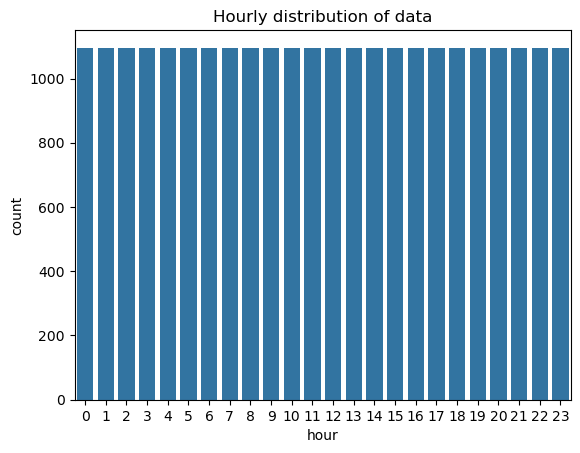

In [12]:
df_ned_json_data['validto'] = pd.to_datetime(df_ned_json_data['validto'])
print(df_ned_json_data['validto'].dtype)
print(df_ned_json_data['validto'].head(1))


import seaborn as sns
import matplotlib.pyplot as plt

df_ned_json_data['hour'] = df_ned_json_data['validto'].dt.hour
sns.countplot(x='hour', data=df_ned_json_data)
plt.title('Hourly distribution of data')
plt.show()

Intereative Plot

In [13]:
import plotly.express as px

df = df_orig_num

# 1. Interactive Time Series Plot
fig_line = px.line(
    df,
    x=df.index,
    y="volume_0",
    title="Interactive Power Generation Volume Time Series",
    labels={"x": "Time", "Volume": "Wh)"},
    template="plotly_dark"
)
fig_line.update_xaxes(rangeslider_visible=True)
fig_line.show()

# 2. Interactive Histogram of Energy Price
fig_hist = px.histogram(
    df,
    x="volume_0",
    nbins=50,
    title="Distribution of Power generation Volume",
    labels={"Volume": "Wh)"},
    template="plotly_dark"
)
fig_hist.update_layout(bargap=0.1)
fig_hist.show()

# 3. Interactive Box Plot for Energy Price
fig_box = px.box(
    df,
    y="volume_0",
    title="Box Plot of Volume",
    labels={"Volume": "Wh)"},
    template="plotly_dark"
)
fig_box.show()

Further analysis 

In [14]:
# 1. Check for Missing Values
print("Missing Values:\n")
print(df_ned_json_data.isnull().sum())
print("\nPercentage of Missing Values:\n")
print((df_ned_json_data.isnull().sum() / len(df_ned_json_data)) * 100)

# 2. Check for Duplicates
print("\nDuplicate Rows:\n")
print(df_ned_json_data.duplicated().sum())

# 3. Check Data Types
print("\nData Types:\n")
print(df_ned_json_data.dtypes)

Missing Values:

validto                           0
capacity_0                        0
volume_0                          0
capacity_1                        0
production_wind                   0
capacity_2                        0
production_solar                  0
capacity_4                        0
production_heatpump               0
capacity_8                        0
production_cofiring               0
capacity_9                        0
production_geothermal             0
capacity_10                       0
production_other                  0
capacity_11                       0
production_waste                  0
capacity_12                       0
production_biooil                 0
capacity_13                       0
production_biomass                0
capacity_14                       0
production_wood                   0
capacity_17                       0
production_windoffshore           0
capacity_18                       0
production_fossilgaspower         0
capacity_19

In [15]:
# 4. Basic Outlier Detection using IQR
print("\nOutlier Detection (IQR Method):\n")
for column in df_ned_json_data.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = df_ned_json_data[column].quantile(0.25)
    Q3 = df_ned_json_data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_ned_json_data[(df_ned_json_data[column] < (Q1 - 1.5 * IQR)) | (df_ned_json_data[column] > (Q3 + 1.5 * IQR))]
    print(f"{column}: {len(outliers)} outliers detected")


Outlier Detection (IQR Method):

capacity_0: 212 outliers detected
volume_0: 212 outliers detected
capacity_1: 0 outliers detected
production_wind: 0 outliers detected
capacity_2: 2069 outliers detected
production_solar: 2069 outliers detected
capacity_4: 736 outliers detected
production_heatpump: 736 outliers detected
capacity_8: 3337 outliers detected
production_cofiring: 3337 outliers detected
capacity_9: 0 outliers detected
production_geothermal: 0 outliers detected
capacity_10: 0 outliers detected
production_other: 0 outliers detected
capacity_11: 0 outliers detected
production_waste: 0 outliers detected
capacity_12: 0 outliers detected
production_biooil: 0 outliers detected
capacity_13: 0 outliers detected
production_biomass: 0 outliers detected
capacity_14: 138 outliers detected
production_wood: 138 outliers detected
capacity_17: 0 outliers detected
production_windoffshore: 0 outliers detected
capacity_18: 0 outliers detected
production_fossilgaspower: 0 outliers detected
capac

In [16]:
# 5. Summary Statistics
print("\nSummary Statistics:\n")
print(df_ned_json_data.describe(include='all'))


Summary Statistics:

                         validto  capacity_0  volume_0  capacity_1  \
count                      26304    2.63e+04  2.63e+04    2.63e+04   
mean   2023-07-02 23:30:00+00:00    1.00e+07  1.00e+07    1.87e+06   
min    2022-01-01 00:00:00+00:00    2.50e+06  2.50e+06    0.00e+00   
25%    2022-10-01 23:45:00+00:00    6.20e+06  6.20e+06    3.82e+05   
50%    2023-07-02 23:30:00+00:00    9.34e+06  9.34e+06    1.31e+06   
75%    2024-04-01 23:15:00+00:00    1.30e+07  1.30e+07    3.05e+06   
max    2024-12-31 23:00:00+00:00    2.92e+07  2.92e+07    6.52e+06   
std                          NaN    4.73e+06  4.73e+06    1.72e+06   

       production_wind  capacity_2  production_solar  capacity_4  \
count         2.63e+04    2.63e+04          2.63e+04    2.63e+04   
mean          1.87e+06    2.47e+06          2.47e+06    6.38e+05   
min           0.00e+00    0.00e+00          0.00e+00    3.93e+04   
25%           3.82e+05    0.00e+00          0.00e+00    2.97e+05   
50%    

Check Co-relation

Highly correlated features:
 [('validto', 'capacity_10'), ('validto', 'production_other'), ('capacity_0', 'volume_0'), ('capacity_1', 'production_wind'), ('capacity_2', 'production_solar'), ('capacity_2', 'capacity_50'), ('capacity_2', 'production_solarthermal'), ('production_solar', 'capacity_50'), ('production_solar', 'production_solarthermal'), ('capacity_4', 'production_heatpump'), ('capacity_8', 'production_cofiring'), ('capacity_9', 'production_geothermal'), ('capacity_9', 'capacity_11'), ('capacity_9', 'production_waste'), ('production_geothermal', 'capacity_11'), ('production_geothermal', 'production_waste'), ('capacity_10', 'production_other'), ('capacity_10', 'capacity_12'), ('capacity_10', 'production_biooil'), ('capacity_10', 'capacity_26'), ('capacity_10', 'production_otherpower'), ('production_other', 'capacity_12'), ('production_other', 'production_biooil'), ('production_other', 'capacity_26'), ('production_other', 'production_otherpower'), ('capacity_11', 'production_waste'), ('capacity_12', 'production_biooil'), ('capacity_12', 'capacity_26'), ('capacity_12', 'production_otherpower'), ('production_biooil', 'capacity_26'), ('production_biooil', 'production_otherpower'), ('capacity_13', 'production_biomass'), ('capacity_14', 'production_wood'), ('capacity_17', 'production_windoffshore'), ('capacity_17', 'capacity_22'), ('capacity_17', 'production_windoffshoreB'), ('capacity_17', 'capacity_51'), ('capacity_17', 'production_allconsuminggas'), ('production_windoffshore', 'capacity_22'), ('production_windoffshore', 'production_windoffshoreB'), ('production_windoffshore', 'capacity_51'), ('production_windoffshore', 'production_allconsuminggas'), ('capacity_18', 'production_fossilgaspower'), ('capacity_19', 'production_fossilhardcoal'), ('capacity_20', 'production_nuclear'), ('capacity_21', 'production_wastepower'), ('capacity_22', 'production_windoffshoreB'), ('capacity_22', 'capacity_51'), ('capacity_22', 'production_allconsuminggas'), ('production_windoffshoreB', 'capacity_51'), ('production_windoffshoreB', 'production_allconsuminggas'), ('capacity_25', 'production_biomasspower'), ('capacity_26', 'production_otherpower'), ('capacity_27', 'production_electricitymix'), ('capacity_28', 'volume_28'), ('capacity_35', 'production_CHP_total'), ('capacity_50', 'production_solarthermal'), ('capacity_51', 'production_allconsuminggas')]

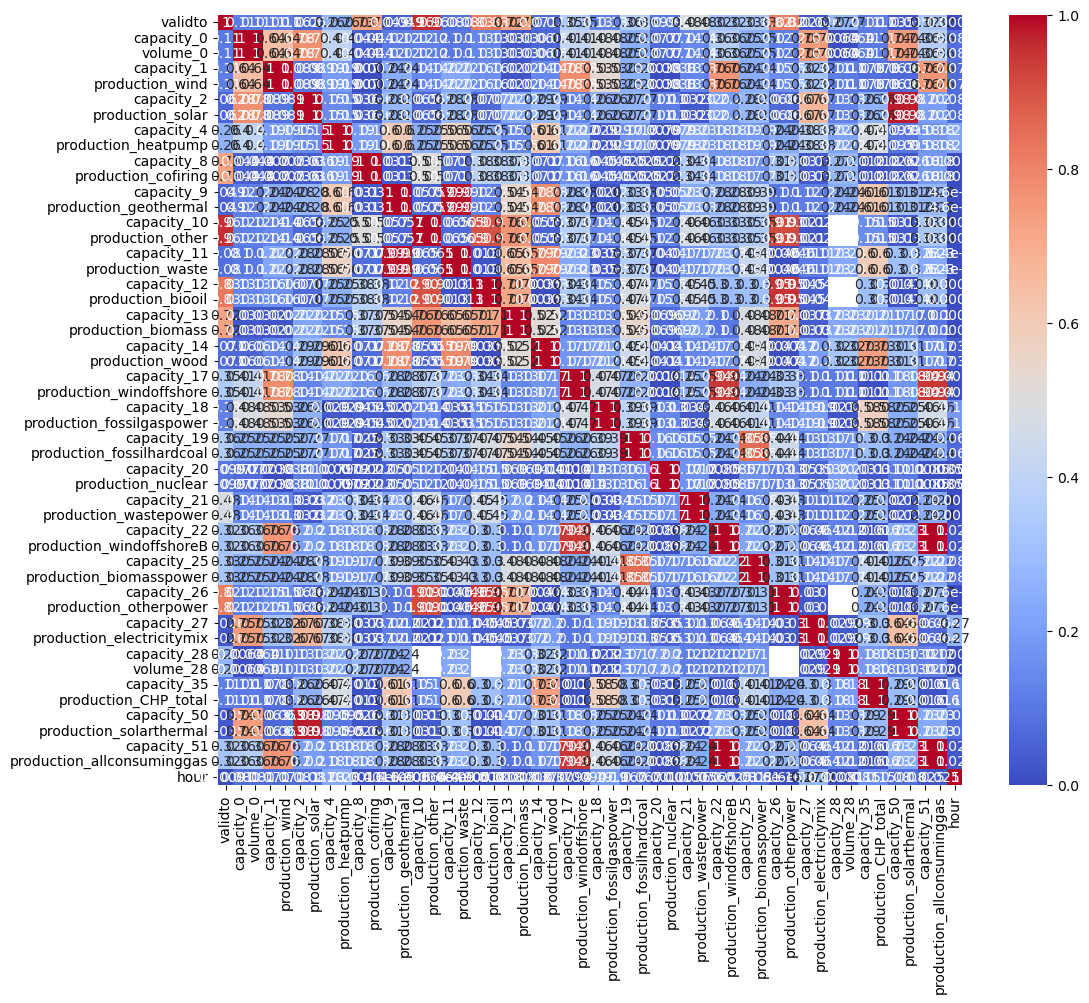

Highly correlated features:
 [('validto', 'capacity_10'), ('validto', 'production_other'), ('capacity_0', 'volume_0'), ('capacity_1', 'production_wind'), ('capacity_2', 'production_solar'), ('capacity_2', 'capacity_50'), ('capacity_2', 'production_solarthermal'), ('production_solar', 'capacity_50'), ('production_solar', 'production_solarthermal'), ('capacity_4', 'production_heatpump'), ('capacity_8', 'production_cofiring'), ('capacity_9', 'production_geothermal'), ('capacity_9', 'capacity_11'), ('capacity_9', 'production_waste'), ('production_geothermal', 'capacity_11'), ('production_geothermal', 'production_waste'), ('capacity_10', 'production_other'), ('capacity_10', 'capacity_12'), ('capacity_10', 'production_biooil'), ('capacity_10', 'capacity_26'), ('capacity_10', 'production_otherpower'), ('production_other', 'capacity_12'), ('production_other', 'production_biooil'), ('production_other', 'capacity_26'), ('production_other', 'production_otherpower'), ('capacity_11', 'production_wa

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_ned_json_data.corr().abs()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Find features with correlation > 0.9
high_corr_var = np.where(corr_matrix > 0.9)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                 for x, y in zip(*high_corr_var) if x != y and x < y]
print("Highly correlated features:\n", high_corr_var)


Univariate Feature Importance

Selected features:
 Index(['capacity_0', 'capacity_1', 'production_wind', 'production_solar',
       'capacity_17', 'production_windoffshore', 'capacity_22',
       'production_windoffshoreB', 'capacity_51',
       'production_allconsuminggas'],
      dtype='object')
/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning:

Features [ 0 11 12 15 16 35 36] are constant.

/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning:

invalid value encountered in divide

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

df = df.dropna()
X = df.drop('volume_0', axis=1)
y = df['volume_0']



selector = SelectKBest(score_func=f_classif, k=10)  # Top 10 features
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:\n", selected_features)


Selected features:
 Index(['capacity_0', 'capacity_1', 'production_wind', 'production_solar',
       'capacity_17', 'production_windoffshore', 'capacity_22',
       'production_windoffshoreB', 'capacity_51',
       'production_allconsuminggas'],
      dtype='object')


/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning:

Features [ 0 11 12 15 16 35 36] are constant.

/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning:

divide by zero encountered in divide

/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning:

invalid value encountered in divide



Feature Importance from Models
Time taken 23m 39.8s

capacity_21                   0.03
production_wastepower         0.03
capacity_4                    0.03
production_heatpump           0.03
volume_28                     0.03
production_cofiring           0.03
production_fossilgaspower     0.03
production_electricitymix     0.03
capacity_28                   0.03
capacity_8                    0.03
capacity_27                   0.03
production_CHP_total          0.03
capacity_18                   0.03
production_wind               0.03
capacity_35                   0.03
capacity_0                    0.03
capacity_1                    0.03
capacity_17                   0.03
production_windoffshore       0.03
production_allconsuminggas    0.03
production_windoffshoreB      0.03
capacity_9                    0.03
capacity_51                   0.03
capacity_22                   0.02
production_solarthermal       0.02
production_geothermal         0.02
capacity_50                   0.02
production_waste              0.02
capacity_13                   0.02
production_biomass            0.02
capacity_11                   0.02
production_biomasspower       0.02
capacity_25                   0.02
capacity_19                   0.02
production_fossilhardcoal     0.02
production_solar              0.02
capacity_2                    0.02
capacity_20                   0.01
production_nuclear            0.01
capacity_14                   0.01
production_wood               0.01
capacity_12                   0.00
capacity_26                   0.00
capacity_10                   0.00
production_other              0.00
production_otherpower         0.00
production_biooil             0.00
dtype: float64

capacity_21                   0.03
production_wastepower         0.03
capacity_4                    0.03
production_heatpump           0.03
volume_28                     0.03
production_cofiring           0.03
production_fossilgaspower     0.03
production_electricitymix     0.03
capacity_28                   0.03
capacity_8                    0.03
capacity_27                   0.03
production_CHP_total          0.03
capacity_18                   0.03
production_wind               0.03
capacity_35                   0.03
capacity_0                    0.03
capacity_1                    0.03
capacity_17                   0.03
production_windoffshore       0.03
production_allconsuminggas    0.03
production_windoffshoreB      0.03
capacity_9                    0.03
capacity_51                   0.03
capacity_22                   0.02
production_solarthermal       0.02
production_geothermal         0.02
capacity_50                   0.02
production_waste              0.02
capacity_13         

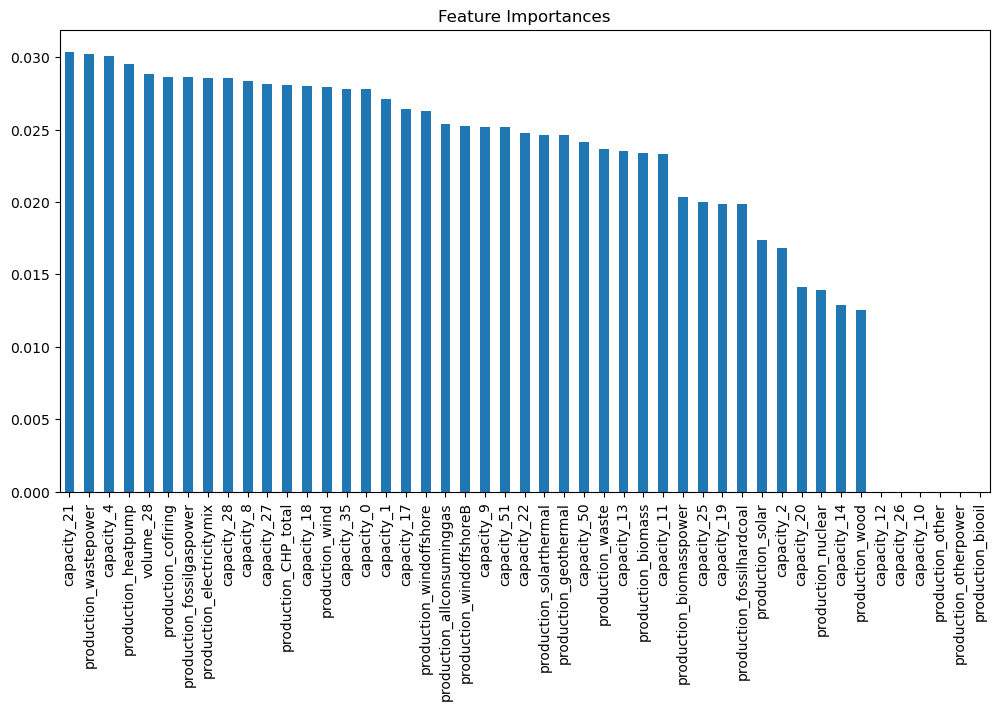

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print(importances)

# Plot
importances.plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importances")
plt.show()


Dimensionality Reduction / PCA Analysis

(6377, 3)
3
Explained variance ratio:
 [0.6817849  0.14594831 0.1249263 ]
Total explained variance: 0.9526595123564077


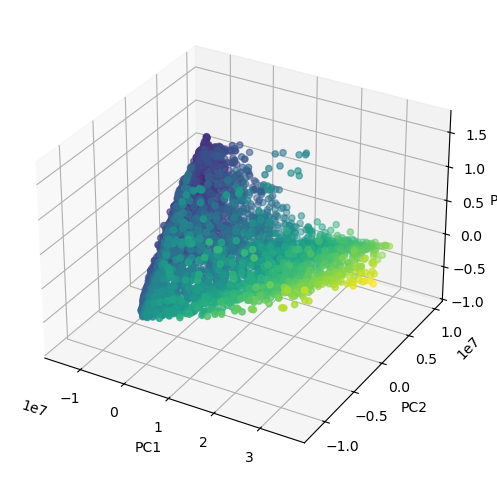

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)  # Reduce to 5 components
X_pca = pca.fit_transform(X)

print(X_pca.shape)
print(pca.n_components_)  # This tells you how many components you kept
print("Explained variance ratio:\n", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])


Use it as your new feature set for modeling and train the regression model

In [37]:
import time

X_pca_df['volumne_0'] = y.reset_index(drop=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# Split features and target
X = X_pca_df.drop('volumne_0', axis=1)
y = X_pca_df['volumne_0']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_run_start_time = time.time()


# Model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Evaluate
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))
print("mean_absolute_percentage_error", mean_absolute_percentage_error(y_test, y_pred))
print("symmetric_mape", symmetric_mape(y_test, y_pred))
print("aic_sarima:", compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1))
print("execution_time:", execution_time)


Mean Squared Error: 107382202.70486659
R^2 Score: 0.999996721088946
mean_absolute_percentage_error 0.030038057432517428
symmetric_mape 0.030041951147715795
aic_sarima: 23605.670800319742
execution_time: 2.5859768390655518


Cluster the data PCA + clustering (like KMeans) is a powerful combo!

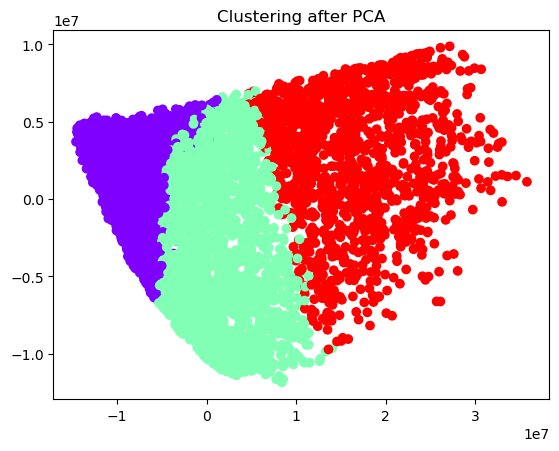

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='rainbow')
plt.title('Clustering after PCA')
plt.show()


Now, to check feature importance with PCA data

In [30]:
importances = model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")


PC1: 1.4332937869308483e-05
PC2: 1.2299910936571481e-06
PC3: 3.1677677748827318e-06
Total Production: 0.9999812693032621
